# Figure 1 - Phase dependent GCM maps
This Jupyter notebooks reproduces Figure 1. The output .png and .pdf files are saved in <em>/figures</em>. Maps of WASP-76 b computed from the GCM output to demonstrate the variation of line-forming pressure and chemical abundances as a function of orbital phase and wavelength.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as mcolors
from matplotlib import colormaps
from numpy import ma
from matplotlib import ticker, cm
from matplotlib.ticker import AutoMinorLocator
import os
import pickle
from scipy.interpolate import RegularGridInterpolator
from matplotlib import gridspec

Read chemistry file to compute chemical abundances along the P-T profiles.

In [15]:
columns2 = ['T','P','el','H','H2','He','C2H2',
           'CH4','CO','CO2','H2O','H2S','HCN',
           'K','Na','NH3','PH3','TIO','VO',
           'Fe', 'Fe+', 'Mg', 'Ca', 'Ti', 'Ti+',
           'V', 'C', 'Cr', 'Ni','Mn','Ca+','Li', 'OH']
df2 = pd.read_csv('../data/gcm/eos_solar_gas_full_hires.dat',
                 names=columns2,skiprows=1,delim_whitespace=True).dropna()

eosH2Ovals=np.zeros((28,46))
eosCOvals=np.zeros((28,46))

tempvalues=np.linspace(500,5000,num=46,endpoint=True) #grid of temperature values
pressures=[1.00000000e-06, 2.15443452e-06, 4.64158919e-06, 1.00000000e-05,
 2.15443452e-05, 4.64158919e-05, 1.00000000e-04, 2.15443304e-04,
 4.64159240e-04, 1.00000000e-03, 2.15443304e-03, 4.64159240e-03,
 1.00000000e-02, 2.15443304e-02, 4.64159240e-02, 1.00000000e-01,
 2.15443304e-01, 4.64159240e-01, 1.00000000e+00, 2.15443304e+00,
 4.64159240e+00, 1.00000000e+01, 2.15443304e+01, 4.64159240e+01,
 1.00000000e+02, 2.15443304e+02, 4.64159240e+02, 1.00000000e+03] #grid of pressure values

tempcount=0
presscount=0
for i in range(1288):
    if tempcount < 46 and presscount < 28:
        eosH2Ovals[presscount,tempcount]=df2['H2O'].iloc[i]
        eosCOvals[presscount,tempcount]=df2['CO'].iloc[i]
        tempcount=tempcount+1
    elif presscount < 28:
        tempcount=0
        presscount=presscount+1
        eosH2Ovals[presscount,tempcount]=df2['H2O'].iloc[i]
        eosCOvals[presscount,tempcount]=df2['CO'].iloc[i]
        tempcount=tempcount+1
        
# Need to reverse the temperature values to match the order of the opacity files
# and then reverse the pressure order 
for j in range(28):
    eosH2Ovals[j,:]=eosH2Ovals[j,::-1]
    eosCOvals[j,:]=eosCOvals[j,::-1]
for p in range(46):
    eosH2Ovals[:,p]=eosH2Ovals[::-1,p]
    eosCOvals[:,p]=eosCOvals[::-1,p]
    
interp_eos_CO = RegularGridInterpolator((tempvalues, pressures), np.log10(eosCOvals.T), bounds_error=False)
interp_eos_H2O = RegularGridInterpolator((tempvalues, pressures), np.log10(eosH2Ovals.T))

Some parameters related to the GCM set up.

In [16]:
nlat = 48
nlon = 96
planet_name = 'WASP76b'
file = planet_name
base = os.path.abspath("../data/gcm/Spec_0_")

This function creates the big temperature maps.

In [17]:
def plot_temperature_map(base, phase, wl, ax, map_type, vmin, vmax, nlevels, opacity_source='continuum', cmap='inferno'):
    if opacity_source == 'CO':
        fend = "_inc_0.0000.00_emission_map.dat"
    if opacity_source == 'continuum':
        fend = "_inc_0.0000.00_emission_map.dat"
    if opacity_source == 'H2O':
        fend = "_inc_0.0000.00_emission_map_H2O.dat"
    
    full_df = pd.read_csv(base + file + "_phase_" + phase + fend,
                names=['tau_index', 'wavelength_m', 'lon', 'lat', 'pressure_pa', 'temp', 'vlos'],
                delim_whitespace=True)

    wavelengths = list(set(full_df["wavelength_m"]))
    wavelengths = np.array(sorted(wavelengths))
    wavelength = wavelengths[np.argmin(np.abs(wavelengths - wl))]

    print('Phase, opacity source = ({}, {})'.format(phase, opacity_source))
    print('Wavelength (tau=2/3) = {:.5f} micron'.format(wavelength*1e6))

    # colormap
    my_colors = plt.get_cmap(cmap)
    df = full_df[full_df["wavelength_m"] == wavelength]

    map = Basemap(projection='ortho',lat_0=0,lon_0=180,resolution='l', ax=ax)
    map.drawparallels(np.arange(-90.,90.,30.))
    map.drawmeridians(np.arange(0.,360.,60.))

    # compute native map projection coordinates of lat/lon grid.
    nlon_vis = int(nlon / 2 + 1)
    lons = np.reshape(list(df.lon), (nlat, nlon_vis))
    lats = np.reshape(list(df.lat), (nlat, nlon_vis))

    x, y = map(lons, lats)

    pressure = np.reshape(list(df.pressure_pa), (nlat, nlon_vis))
    temperature = np.reshape(list(df.temp), (nlat, nlon_vis))
    abundance = np.zeros(shape=(nlat, nlon_vis))
    for a in range(nlat):
        for b in range(nlon_vis):
            if opacity_source == 'CO':
                abundance[a,b] = interp_eos_CO((temperature[a,b],pressure[a,b]/1e5))
            elif opacity_source == 'H2O':
                abundance[a,b] = interp_eos_H2O((temperature[a,b],pressure[a,b]/1e5))
            else:
                pass
    # This is in mbar, thats where the 1e2 comes from. 1e5 to Pa, 1e3 to mbar
    if map_type == 'temperature':
        print('Temperature range ({:.0f}, {:.0f}, {:.0f})'.format(np.min(temperature), np.median(temperature), np.max(temperature)))
        emap = map.contourf(x, y, temperature,
                            levels=np.linspace(vmin, vmax, nlevels),
                            cmap=my_colors)
    if map_type == 'pressure':
        print('Pressure range ({:.2f}, {:.2f}, {:.2f})'.format(np.min(np.log10(pressure/1e5)), np.median(np.log10(pressure/1e5)), np.max(np.log10(pressure/1e5))))
        emap = map.contourf(x, y, np.log10(pressure/1e5),
                            levels=np.linspace(vmin, vmax, nlevels),
                            cmap=my_colors)
        pickle.dump([x,y,pressure], open(f'../data/gcm/tau_2_3_map_{phase}_{opacity_source}', 'wb'))
        
    if map_type == 'abundance':
        print('Abundance range ({:.2f}, {:.2f}, {:.2f})'.format(np.min(abundance), np.median(abundance), np.max(abundance)))
        emap = map.contourf(x, y, abundance,
                    levels=np.linspace(vmin, vmax, nlevels),
                    cmap=my_colors)

    wav_str = str(np.round(wavelengths[0] * 1e6, 5))
    cb = map.colorbar(emap,
                      location='bottom')

    cb.ax.minorticks_on()
    print('\n')
    return ax, cb

Create the plot for the figure.

Phase, opacity source = (195, continuum)
Wavelength (tau=2/3) = 2.29520 micron
Temperature range (1532, 2385, 3043)


Phase, opacity source = (232.5, continuum)
Wavelength (tau=2/3) = 2.29520 micron
Temperature range (1455, 2080, 3048)


Phase, opacity source = (195, continuum)
Wavelength (tau=2/3) = 2.29520 micron
Pressure range (-1.12, -0.96, -0.82)


Phase, opacity source = (232.5, continuum)
Wavelength (tau=2/3) = 2.29520 micron
Pressure range (-1.11, -0.93, -0.76)


Phase, opacity source = (195, CO)
Wavelength (tau=2/3) = 2.29540 micron
Abundance range (-3.60, -3.59, -3.57)


Phase, opacity source = (232.5, CO)
Wavelength (tau=2/3) = 2.29540 micron
Abundance range (-3.62, -3.58, -3.34)


Phase, opacity source = (195, CO)
Wavelength (tau=2/3) = 2.29540 micron
Pressure range (-3.89, -3.75, -3.49)


Phase, opacity source = (232.5, CO)
Wavelength (tau=2/3) = 2.29540 micron
Pressure range (-4.09, -3.73, -3.23)


Phase, opacity source = (195, H2O)
Wavelength (tau=2/3) = 1.83128 micron
A

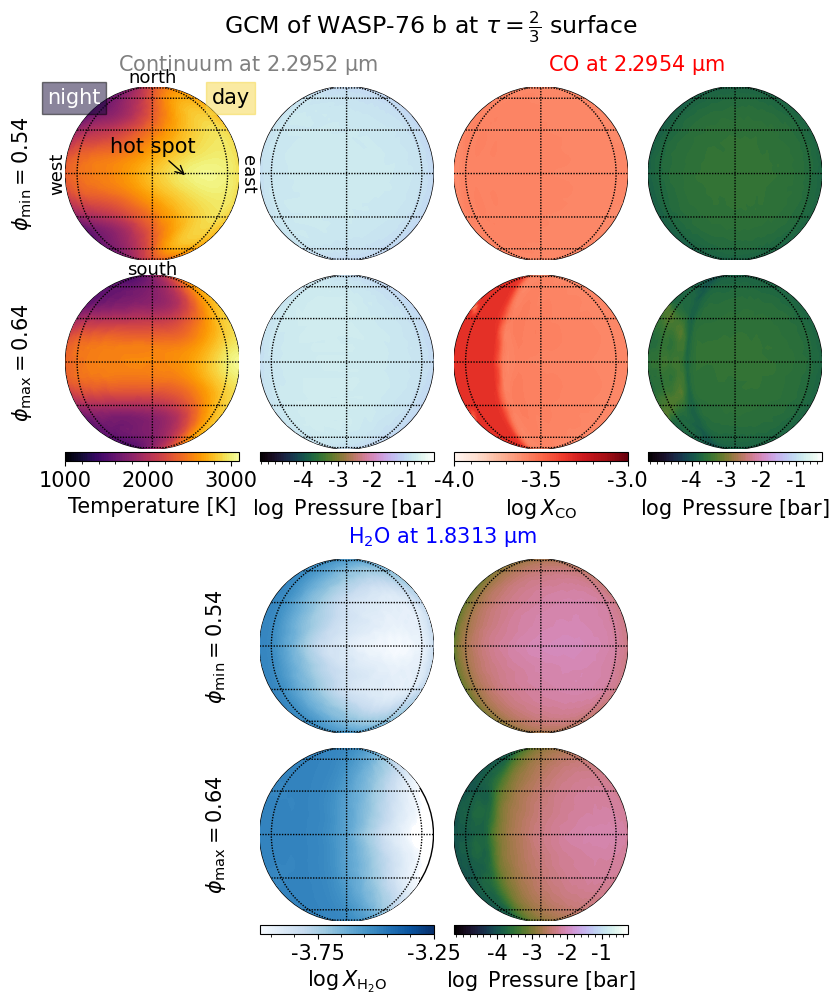

In [18]:
# Colar map to use for day and nightsides
cmap = colormaps['inferno']
c1 = cmap(0.1)
c2 = cmap(0.9)

# Define all axes
fig = plt.figure(figsize=(10,11))
gs = gridspec.GridSpec(nrows=5, ncols=4, hspace=0.015, wspace=0.01, width_ratios=[1,1,1,1], height_ratios=[1,1,0.5,1,1])

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])

ax11 = fig.add_subplot(gs[0,1])
ax12 = fig.add_subplot(gs[1,1])

ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[1,2])
ax5 = fig.add_subplot(gs[0,3])
ax6 = fig.add_subplot(gs[1,3])

ax7 = fig.add_subplot(gs[3,1])
ax8 = fig.add_subplot(gs[4,1])

ax9 = fig.add_subplot(gs[3,2])
ax10 = fig.add_subplot(gs[4,2])

# Plot all maps
ax1, cb1 = plot_temperature_map(base,phase='195',wl = 2.295197e-6, ax=ax1,
                              map_type='temperature', vmin=1000, vmax=3100, nlevels=100,
                             cmap='inferno', opacity_source='continuum')
ax1.annotate(r'$\phi_{\rm{min}} = 0.54$', 
              xy=(-0.25,0.5), xycoords='axes fraction', va='center', ha='center',
             fontsize=15, rotation=90)
ax7.annotate(r'$\phi_{\rm{min}} = 0.54$', 
              xy=(-0.25,0.5), xycoords='axes fraction', va='center', ha='center',
             fontsize=15, rotation=90)

ax1.annotate('night', xy=(0.05,0.9), xycoords='axes fraction', fontsize=15, color='w', ha='center', bbox=dict(facecolor=c1, alpha=0.5, edgecolor='k'))
ax1.annotate('day', xy=(0.95,0.9), xycoords='axes fraction', fontsize=15, color='k', ha='center', bbox=dict(facecolor=c2, alpha=0.5, edgecolor=c2))
ax1.annotate('hot spot', xy=(0.7,0.48), xytext=(0.5, 0.6), xycoords='axes fraction', fontsize=15, color='k', va='bottom', ha='center',
             arrowprops=dict(facecolor='black', arrowstyle="->"))
ax1.annotate('west', xy=(-0.05,0.5), xycoords='axes fraction', fontsize=13, color='k', ha='center', va='center', rotation=90)
ax1.annotate('east', xy=(1.05,0.5), xycoords='axes fraction', fontsize=13, color='k', ha='center', va='center', rotation=-90)
ax1.annotate('north', xy=(0.5,1.05), xycoords='axes fraction', fontsize=13, color='k', ha='center', va='center')
ax1.annotate('south', xy=(0.5,-0.05), xycoords='axes fraction', fontsize=13, color='k', ha='center', va='center')

cb1.remove()

ax1.set_title(r'Continuum at 2.2952 $\rm{\mu}$m', color='gray', size=15, y=1.08, x=1.05, va='center', ha='center')


ax2, cb2 = plot_temperature_map(base,phase='232.5',wl = 2.295197e-6, ax=ax2,
                              map_type='temperature', vmin=1000, vmax=3100, nlevels=100,
                             cmap='inferno', opacity_source='continuum')
ax2.annotate(r'$\phi_{\rm{max}} = 0.64$', xy=(-0.25,0.5),
              xycoords='axes fraction', va='center', ha='center',
             fontsize=15, rotation=90)
ax8.annotate(r'$\phi_{\rm{max}} = 0.64$', xy=(-0.25,0.5),
              xycoords='axes fraction', va='center', ha='center',
             fontsize=15, rotation=90)

ticks = np.linspace(1000, 3000, 3)
cb2.set_ticks(ticks)
cb2.set_ticklabels([f"{tick:.0f}" for tick in ticks], fontsize=15) 
cb2.set_label(r'Temperature [K]', size=15)



ax11, cb11 = plot_temperature_map(base,phase='195',wl = 2.295197e-6, ax=ax11,
                              map_type='pressure', vmin=-5.25, vmax=-0.25, nlevels=100,
                             cmap='cubehelix', opacity_source='continuum')
cb11.remove()
ax12, cb12 = plot_temperature_map(base,phase='232.5',wl = 2.295197e-6, ax=ax12,
                              map_type='pressure', vmin=-5.25, vmax=-0.25, nlevels=100,
                             cmap='cubehelix', opacity_source='continuum')
ticks = np.array([-4,-3,-2,-1])
cb12.set_ticks(ticks)
cb12.set_ticklabels([f"{tick:.0f}" for tick in ticks], fontsize=15) 
cb12.set_label(r'$\log$ ' + r'Pressure [bar]', size=15)




ax3, cb3 = plot_temperature_map(base,phase='195',wl = 2.2954087e-6, ax=ax3,
                              map_type='abundance', vmin=-4., vmax=-3., nlevels=100,
                             cmap='Reds', opacity_source='CO')
ax3.set_title( r'CO at 2.2954 $\rm{\mu}$m', color='r', size=15, y=1.08, x=1.05, va='center', ha='center')
cb3.remove()

ax4, cb4 = plot_temperature_map(base,phase='232.5',wl = 2.2954087e-6, ax=ax4,
                              map_type='abundance', vmin=-4, vmax=-3., nlevels=100,
                             cmap='Reds', opacity_source='CO')

ticks = np.array([-4, -3.5, -3])
cb4.set_ticks(ticks)
cb4.set_ticklabels([f"{tick:.1f}" for tick in ticks], fontsize=15) 
cb4.set_label(r'$\log X_{\rm{CO}}$', size=15)

ax5, cb5 = plot_temperature_map(base,phase='195',wl = 2.2954087e-6, ax=ax5,
                              map_type='pressure', vmin=-5.25, vmax=-0.25, nlevels=100,
                             cmap='cubehelix', opacity_source='CO')
cb5.remove()
ax6, cb6 = plot_temperature_map(base,phase='232.5',wl = 2.2954087e-6, ax=ax6,
                              map_type='pressure', vmin=-5.25, vmax=-0.25, nlevels=100,
                             cmap='cubehelix', opacity_source='CO')
ticks = np.array([-4.,-3,-2,-1])
cb6.set_ticks(ticks)
cb6.set_ticklabels([f"{tick:.0f}" for tick in ticks], fontsize=15) 
cb6.set_label(r'$\log$ ' + r'Pressure [bar]', size=15)

ax7.set_title(r'H$_2$O at 1.8313 $\rm{\mu}$m', color='b', size=15, y=1.08, x=1.05, va='center', ha='center')
ax7, cb7 = plot_temperature_map(base,phase='195',wl = 1.831278e-6, ax=ax7,
                              map_type='abundance', vmin=-4., vmax=-3.25, nlevels=100,
                             cmap='Blues', opacity_source='H2O')
cb7.remove()

ax8, cb8 = plot_temperature_map(base,phase='232.5',wl = 1.831278e-6, ax=ax8,
                              map_type='abundance', vmin=-4, vmax=-3.25, nlevels=100,
                             cmap='Blues', opacity_source='H2O')
ticks = np.array([-3.75, -3.25])  # Generate 5 linearly spaced ticks from 1000 to 2000
cb8.set_ticks(ticks)  # Set these ticks on the colorbar
cb8.set_ticklabels([f"{tick:.2f}" for tick in ticks], fontsize=15) 
cb8.set_label(r'$\log X_{\rm{H_{2}O}}$', size=15)

ax9, cb9 = plot_temperature_map(base,phase='195',wl = 1.831278e-6, ax=ax9,
                              map_type='pressure', vmin=-5.25, vmax=-0.25, nlevels=100,
                             cmap='cubehelix', opacity_source='H2O')
cb9.remove()
ax10, cb10 = plot_temperature_map(base,phase='232.5',wl = 1.831278e-6, ax=ax10,
                              map_type='pressure', vmin=-5.25, vmax=-0.25, nlevels=100,
                             cmap='cubehelix',opacity_source='H2O')

ticks = np.array([-4,-3,-2,-1])
cb10.set_ticks(ticks)
cb10.set_ticklabels([f"{tick:.0f}" for tick in ticks], fontsize=15) 
cb10.set_label(r'$\log$ ' + r'Pressure [bar]', size=15)

ax10.annotate(' ', xy=(1.05,0.5), xycoords='axes fraction', fontsize=15, color='k', ha='center', va='center', rotation=-90)
ax9.annotate(' ', xy=(1.05,0.5), xycoords='axes fraction', fontsize=15, color='k', ha='center', va='center', rotation=-90)

plt.suptitle(r'GCM of WASP-76 b at $\tau=\frac{2}{3}$ surface', size=17, y=0.95)

# Save the output figure
plt.savefig('../figures/Fig1_phase_dependent_gcm_maps.png', dpi=200, bbox_inches='tight')
plt.savefig('../figures/Fig1_phase_dependent_gcm_maps.pdf',bbox_inches='tight')
plt.show()